<a href="https://colab.research.google.com/github/juniorbr007/Clusterizacao_prf/blob/main/aula_clusterizacao_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula prática — Clusterização com dados de acidentes (PE)

(K-Means → DBSCAN → Fuzzy C-Means → GMM → Mean-Shift → Dendrograma)

###Etapas

####Montagem do drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Alguns instaladores

In [ ]:
!pip -q install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 8.2 MB/s eta 0:00:00


####Imports

In [ ]:
# === Pacotes básicos ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

# === SciPy ===
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# === Scikit-learn ===
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

# === Fuzzy Clustering ===
import skfuzzy as fuzz

# === Extra (para GMM visual) ===
from matplotlib.patches import Ellipse



####Dataset

Features selecionadas:

data_inversa,
dia_semana,
horario,
municipio,
causa_acidente,
tipo_acidente,
condicao_metereologica,
tipo_pista,
tipo_veiculo,
estado_fisico,
idade,
ilesos,
feridos_leves,
feridos_graves,
mortos,
latitude,
longitude

In [ ]:
DATA_PATH = '/content/drive/MyDrive/IC - Carmelo/Clusterização/acidentes_unificado.csv'

# Carregar dados
df = pd.read_csv(DATA_PATH, low_memory=False)

# Filtrar apenas Pernambuco
df_pe = df[df['uf'].astype(str).str.upper() == 'PE'].copy()

# Restringir colunas relevantes
colunas = [
    "dia_semana", "data_inversa", "horario", "municipio", "causa_acidente", "tipo_acidente",
    "condicao_metereologica", "tipo_pista", "tipo_veiculo", "estado_fisico",
    "idade", "ilesos", "feridos_leves", "feridos_graves", "mortos",
    "latitude", "longitude"
]
df_pe = df_pe.loc[:, df_pe.columns.intersection(colunas)].copy()

print("Shape final:", df_pe.shape)

# Funções auxiliares
def extract_hour(s):
    return pd.to_numeric(s.astype(str).str.split(':').str[0], errors='coerce')

def map_weekday(s):
    m = {
        'segunda-feira':0, 'terça-feira':1, 'terca-feira':1,
        'quarta-feira':2, 'quinta-feira':3, 'sexta-feira':4,
        'sábado':5, 'sabado':5, 'domingo':6
    }
    return s.astype(str).str.lower().map(m)

def to_cyclic(x, period):
    rad = 2*np.pi*(pd.to_numeric(x, errors='coerce') % period)/period
    return np.sin(rad), np.cos(rad)

# Pré-processamento inicial
hora  = extract_hour(df_pe['horario']) if 'horario' in df_pe.columns else pd.Series(dtype='float64')
dia   = map_weekday(df_pe['dia_semana']) if 'dia_semana' in df_pe.columns else pd.Series(dtype='float64')
idade = pd.to_numeric(df_pe['idade'], errors='coerce') if 'idade' in df_pe.columns else pd.Series(dtype='float64')
lat   = pd.to_numeric(df_pe['latitude'], errors='coerce') if 'latitude' in df_pe.columns else pd.Series(dtype='float64')
lon   = pd.to_numeric(df_pe['longitude'], errors='coerce') if 'longitude' in df_pe.columns else pd.Series(dtype='float64')

df_pe.head()


Shape final: (132724, 17)


,data_inversa,dia_semana,horario,municipio,causa_acidente,tipo_acidente,condicao_metereologica,tipo_pista,tipo_veiculo,estado_fisico,idade,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude
91,2018-01-01,segunda-feira,03:20:00,POMBOS,Condutor Dormindo,Colisão com objeto estático,Céu Claro,Dupla,Automóvel,Lesões Graves,28.0,0.0,0.0,1.0,0.0,-8.147220,-35.397579
92,2018-01-01,segunda-feira,03:20:00,POMBOS,Condutor Dormindo,Capotamento,Céu Claro,Dupla,Automóvel,Lesões Graves,28.0,0.0,0.0,1.0,0.0,-8.147220,-35.397579
101,2018-01-01,segunda-feira,03:30:00,RECIFE,Falta de Atenção à Condução,Saída de leito carroçável,Céu Claro,Múltipla,Motocicleta,Lesões Leves,44.0,0.0,1.0,0.0,0.0,-8.063598,-34.944449
102,2018-01-01,segunda-feira,03:30:00,RECIFE,Condutor Dormindo,Saída de leito carroçável,Céu Claro,Múltipla,Motocicleta,Lesões Leves,44.0,0.0,1.0,0.0,0.0,-8.063598,-34.944449
103,2018-01-01,segunda-feira,03:30:00,RECIFE,Falta de Atenção à Condução,Colisão com objeto estático,Céu Claro,Múltipla,Motocicleta,Lesões Leves,44.0,0.0,1.0,0.0,0.0,-8.063598,-34.944449


## K-Means — hora x dia da semana

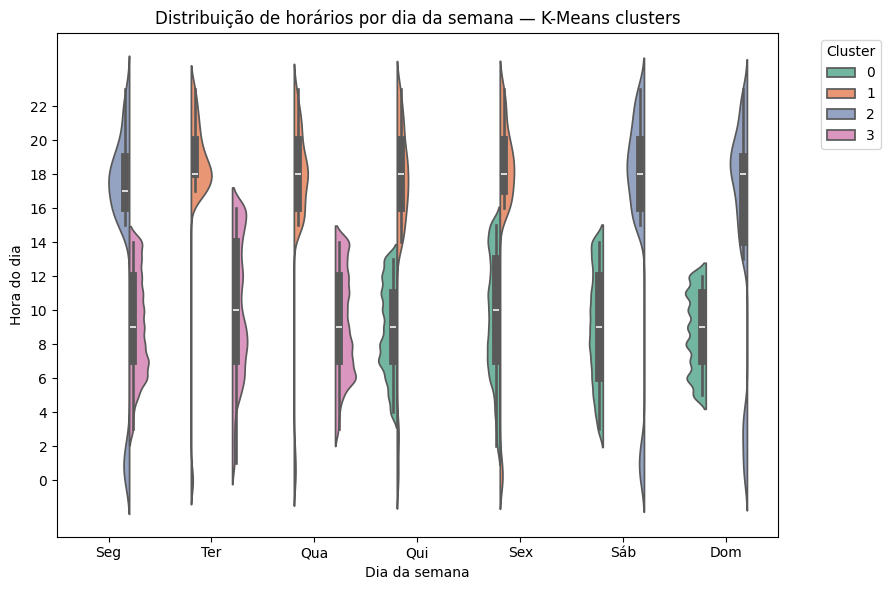

In [ ]:
base = pd.DataFrame({'hora': hora, 'dia': dia}).dropna()
base = base[(base['hora'].between(0,23)) & (base['dia'].between(0,6))]

# Transformação cíclica
rh = 2*np.pi*base['hora'].to_numpy()/24.0
rw = 2*np.pi*base['dia' ].to_numpy()/7.0
X = np.column_stack([np.sin(rh), np.cos(rh), np.sin(rw), np.cos(rw)]).astype(np.float32)
X = StandardScaler().fit_transform(X)

# KMeans
k = 4 #Por enquanto, vamos definir nós mesmos esta quantidade de clusters
km = KMeans(n_clusters=k, random_state=42, n_init=15)
base['cluster'] = km.fit_predict(X)

# Gráfico
plt.figure(figsize=(9,6))
sns.violinplot(data=base, x='dia', y='hora', hue='cluster', split=True, palette='Set2')

plt.xticks(range(7), ['Seg','Ter','Qua','Qui','Sex','Sáb','Dom'])
plt.yticks(range(0,24,2))
plt.xlabel('Dia da semana')
plt.ylabel('Hora do dia')
plt.title('Distribuição de horários por dia da semana — K-Means clusters')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



## DBSCAN — geográfico

/tmp/ipython-input-3945388717.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cluster")


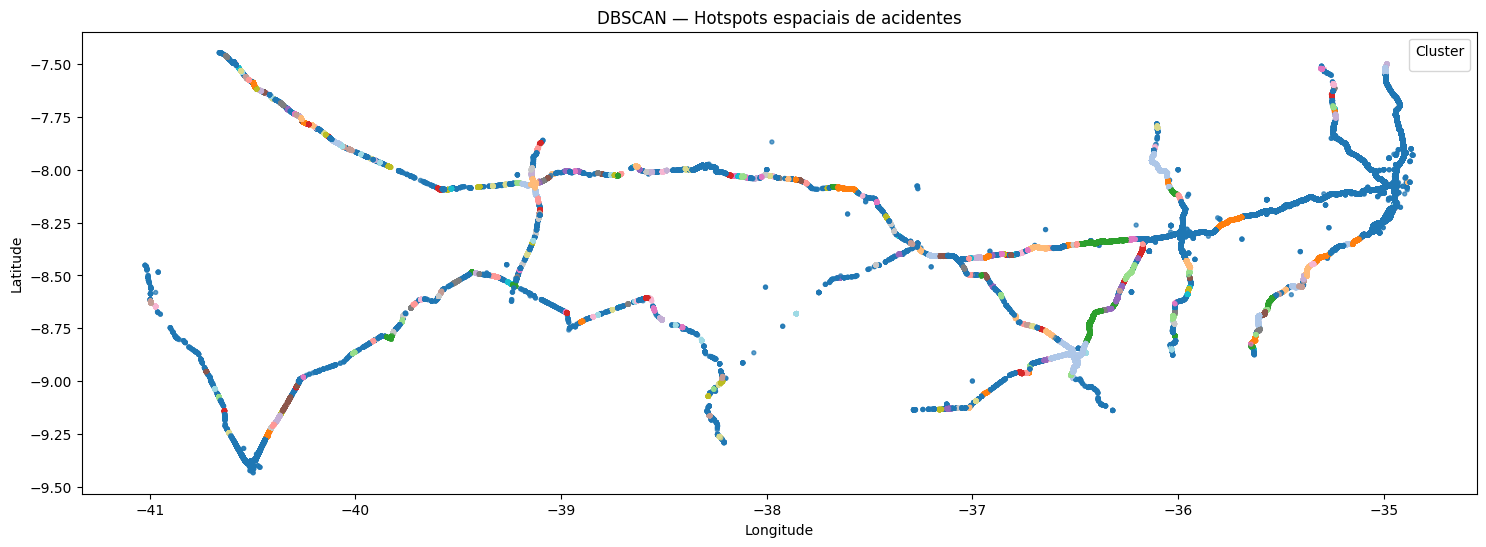

In [ ]:
geo = pd.DataFrame({
    'lat': pd.to_numeric(df_pe['latitude'], errors='coerce'),
    'lon': pd.to_numeric(df_pe['longitude'], errors='coerce')
}).dropna()
# Filtro da região
mask = geo['lat'].between(-9.8, -7.0) & geo['lon'].between(-41.6, -34.6)
geo = geo[mask]

# DBSCAN
coords = np.radians(geo[['lat','lon']].to_numpy())
db = DBSCAN(eps=0.8/6371.0088, min_samples=30, metric='haversine')
lab = db.fit_predict(coords)

# Garantir alinhamento labels com o geo
geo = geo.iloc[:len(lab)].copy()
geo["Cluster"] = lab

plt.figure(figsize=(18,6))
plt.scatter(geo['lon'], geo['lat'], c=geo["Cluster"], cmap="tab20", s=8, alpha=0.7)
plt.title("DBSCAN — Hotspots espaciais de acidentes")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()


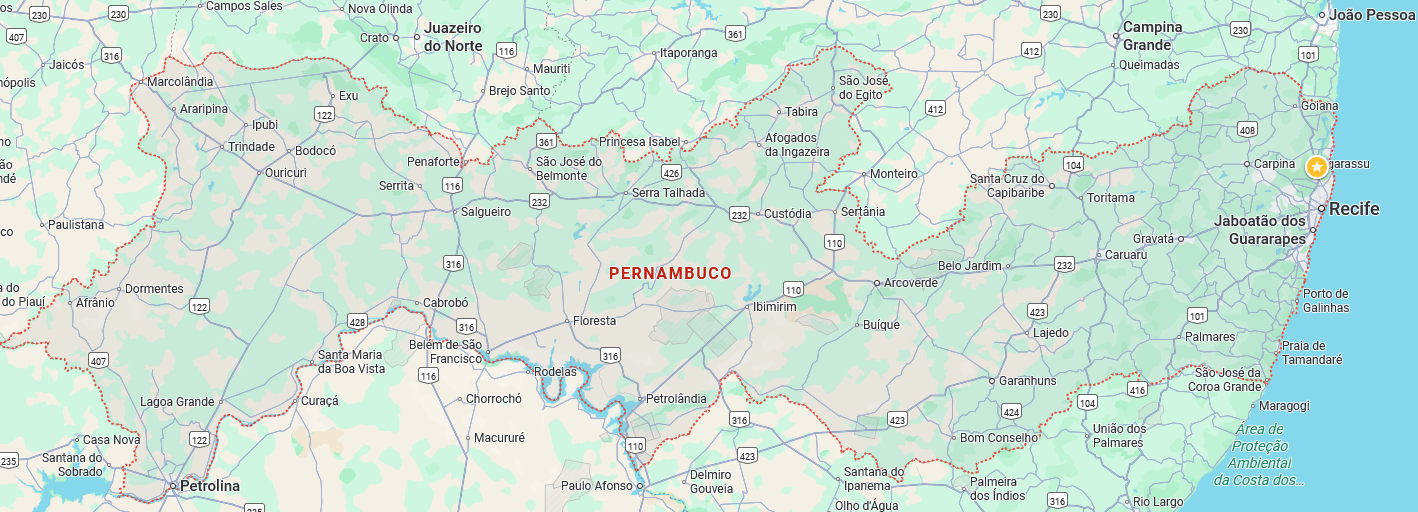

## Fuzzy C-Means — geográfico

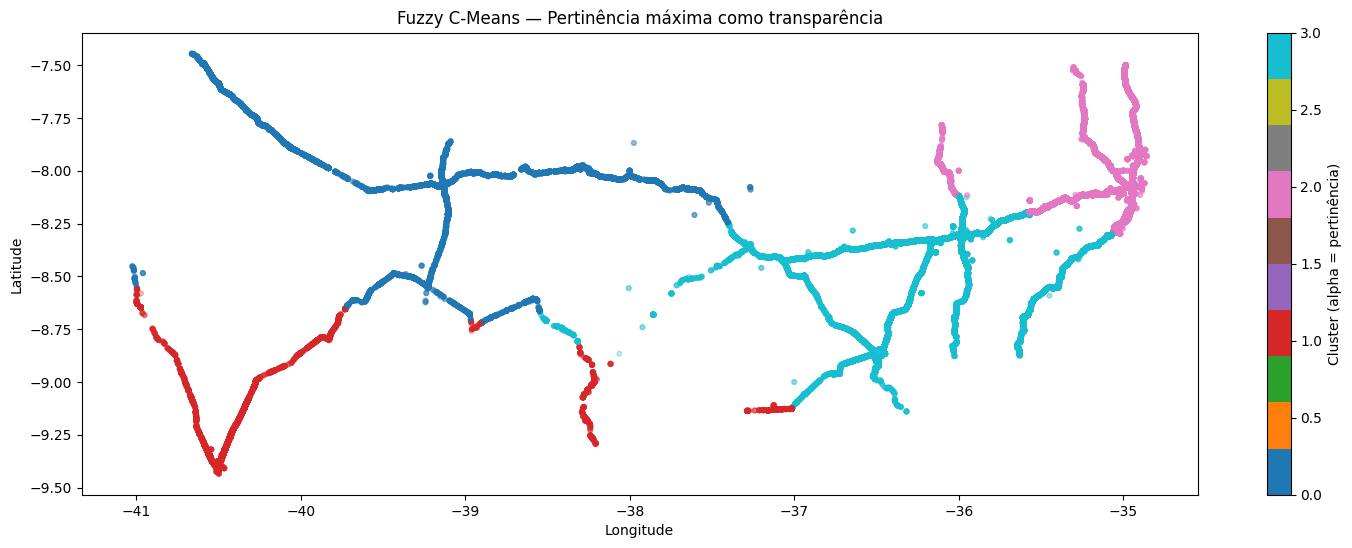

In [ ]:
geo = pd.DataFrame({'lat': lat, 'lon': lon}).dropna()
geo = geo[(geo['lat'].between(-9.8,-7.0)) & (geo['lon'].between(-41.6,-34.6))]

# Normalização
lat_z = StandardScaler().fit_transform(geo[['lat']]).ravel()
lon_z = StandardScaler().fit_transform(geo[['lon']]).ravel()
X = np.column_stack([lat_z, lon_z]).T

# Fuzzy C-Means
c = 4
cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
    X, c=c, m=4.0, error=1e-5, maxiter=1000, seed=42
)
lab = u.argmax(axis=0)

# Plot
pertinencia_max = u.max(axis=0)
plt.figure(figsize=(18,6))
sc = plt.scatter(
    geo['lon'], geo['lat'],
    c=lab, cmap="tab10", s=12, alpha=pertinencia_max
)
plt.colorbar(sc, label="Cluster (alpha = pertinência)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Fuzzy C-Means — Pertinência máxima como transparência")
plt.show()



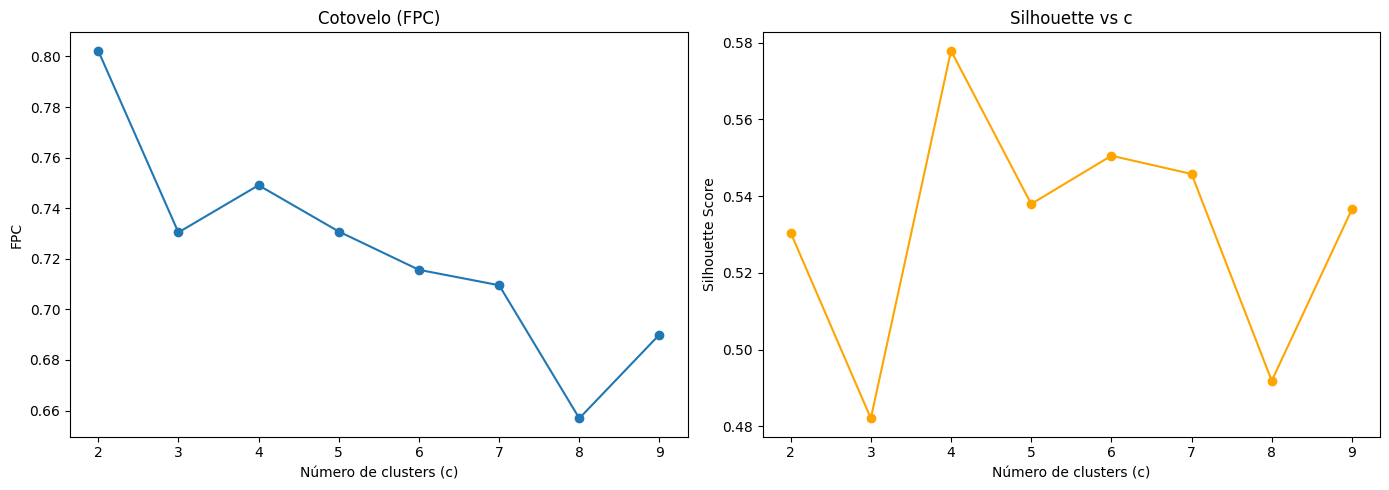

Melhor número de clusters sugerido (Silhouette): 4


In [ ]:
from sklearn.metrics import silhouette_score

# Amostra reduzida para acelerar
geo_sample = geo.sample(frac=1, random_state=42)
lat_z = StandardScaler().fit_transform(geo_sample[['lat']]).ravel()
lon_z = StandardScaler().fit_transform(geo_sample[['lon']]).ravel()
X_sample = np.column_stack([lat_z, lon_z]).T

fpcs, sils = [], []
c_values = range(2, 10)  # faixa de clusters testados

for c in c_values:
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_sample, c=c, m=2.0, error=1e-4, maxiter=500, seed=42
    )
    lab = u.argmax(axis=0)
    fpcs.append(fpc)
    if len(set(lab)) > 1:
        sils.append(silhouette_score(X_sample.T, lab))
    else:
        sils.append(-1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(c_values, fpcs, marker="o")
plt.xlabel("Número de clusters (c)")
plt.ylabel("FPC")
plt.title("Cotovelo (FPC)")

plt.subplot(1,2,2)
plt.plot(c_values, sils, marker="o", color="orange")
plt.xlabel("Número de clusters (c)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs c")

plt.tight_layout()
plt.show()

# Sugestão automática de melhor c
c_otimo = c_values[np.argmax(sils)]
print("Melhor número de clusters sugerido (Silhouette):", c_otimo)


## GMM — hora × qtd acidentes + elipses

Melhor k pelo BIC: 9
Melhor k pelo AIC: 9


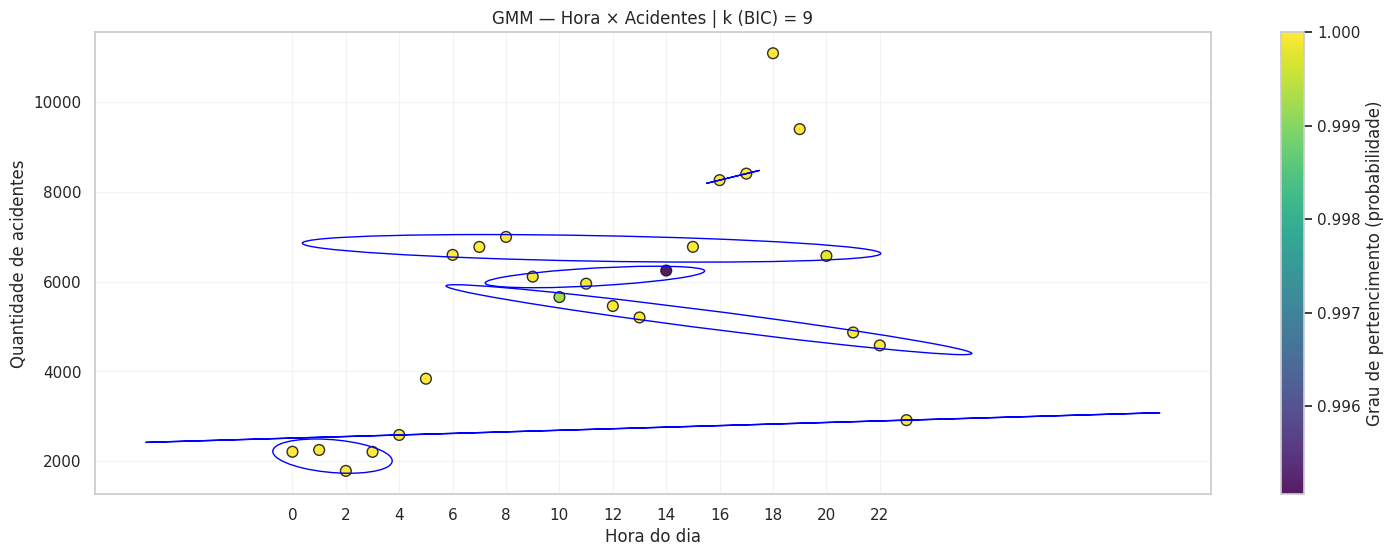

In [ ]:
base = pd.DataFrame({'hora': hora}).dropna()
base = base[(base['hora'].between(0,23))]
contagem = base.groupby('hora').size().reset_index(name='qtd')

X = contagem[['hora','qtd']].to_numpy()

# vários valores de k
n_components = range(1, 10)
bics, aics = [], []

for k in n_components:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))
    aics.append(gmm.aic(X))

best_k_bic = n_components[np.argmin(bics)]
best_k_aic = n_components[np.argmin(aics)]
print("Melhor k pelo BIC:", best_k_bic)
print("Melhor k pelo AIC:", best_k_aic)

# GMM com o k escolhido (via BIC)
gmm = GaussianMixture(n_components=best_k_bic, covariance_type='full', random_state=42)
labels = gmm.fit_predict(X)
probs = gmm.predict_proba(X).max(axis=1)

# Plot
plt.figure(figsize=(18,6))
scatter = plt.scatter(
    contagem['hora'], contagem['qtd'],
    c=probs, s=60, cmap="viridis", alpha=0.9, edgecolor="k"
)

def draw_ellipse(mean, cov, ax, n_std=2.0, **kw):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ell = Ellipse(xy=mean, width=width, height=height, angle=theta,
                  fill=False, edgecolor="blue", linewidth=1.0, **kw)
    ax.add_patch(ell)

ax = plt.gca()
for m, cov in zip(gmm.means_, gmm.covariances_):
    draw_ellipse(m, cov, ax)

plt.colorbar(scatter, label="Grau de pertencimento (probabilidade)")
plt.xticks(range(0,24,2))
plt.xlabel("Hora do dia"); plt.ylabel("Quantidade de acidentes")
plt.title(f"GMM — Hora × Acidentes | k (BIC) = {best_k_bic}")
plt.grid(alpha=0.2)
plt.show()


## Mean-Shift — geolocalização + centros

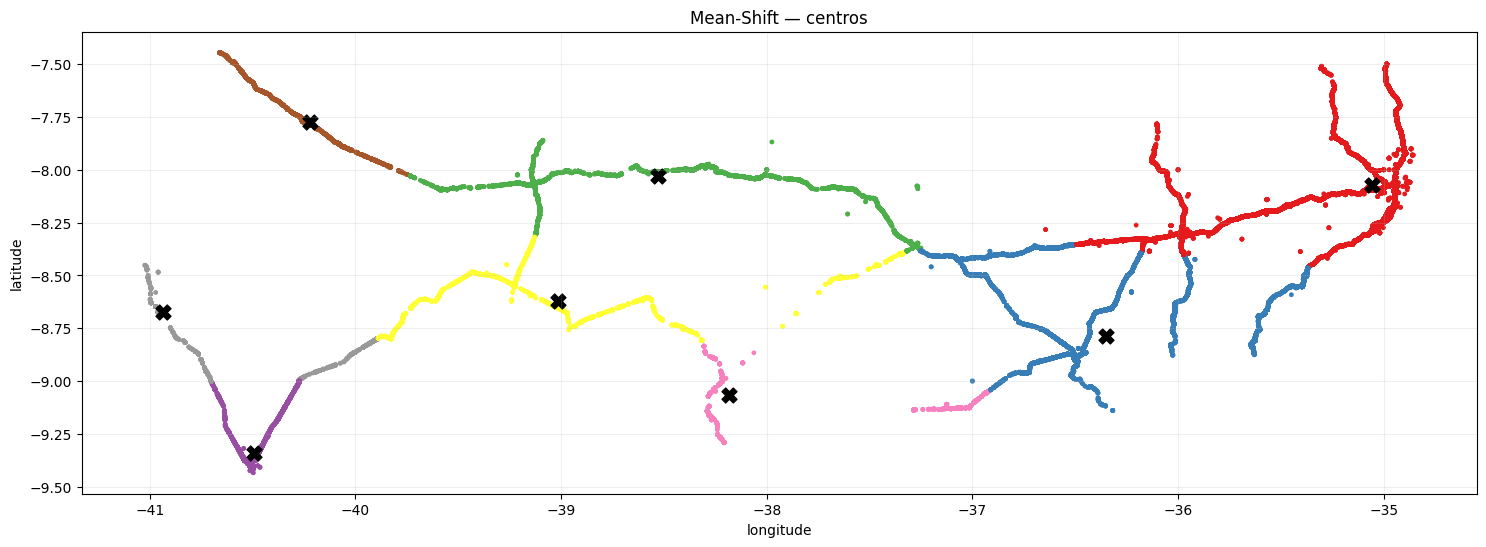

In [ ]:
geo = pd.DataFrame({'lat':lat, 'lon':lon}).dropna()
mask = geo['lat'].between(-9.8,-7.0) & geo['lon'].between(-41.6,-34.6)
geo = geo[mask]
# Normalização
sc = StandardScaler().fit(geo[['lat','lon']].to_numpy().astype(np.float32))
Xn = sc.transform(geo[['lat','lon']].to_numpy().astype(np.float32))

# Estimar largura de banda e aplicar Mean-Shift
bw = estimate_bandwidth(Xn, quantile=0.1, n_samples=min(5000,len(Xn)), random_state=42)
ms = MeanShift(bandwidth=bw, bin_seeding=True, cluster_all=True)
lab = ms.fit_predict(Xn)
centers = sc.inverse_transform(ms.cluster_centers_)

# Plot por cluster
plt.figure(figsize=(18,6))
plt.scatter(geo['lon'], geo['lat'], c=lab, s=6, cmap="Set1")
plt.scatter(centers[:,1], centers[:,0], marker='X', s=120, linewidths=0.8, c="black")
plt.xlabel('longitude'); plt.ylabel('latitude'); plt.title('Mean-Shift — centros')
plt.grid(alpha=0.2); plt.show()




## Dendrograma — município x perfil acidente x mês

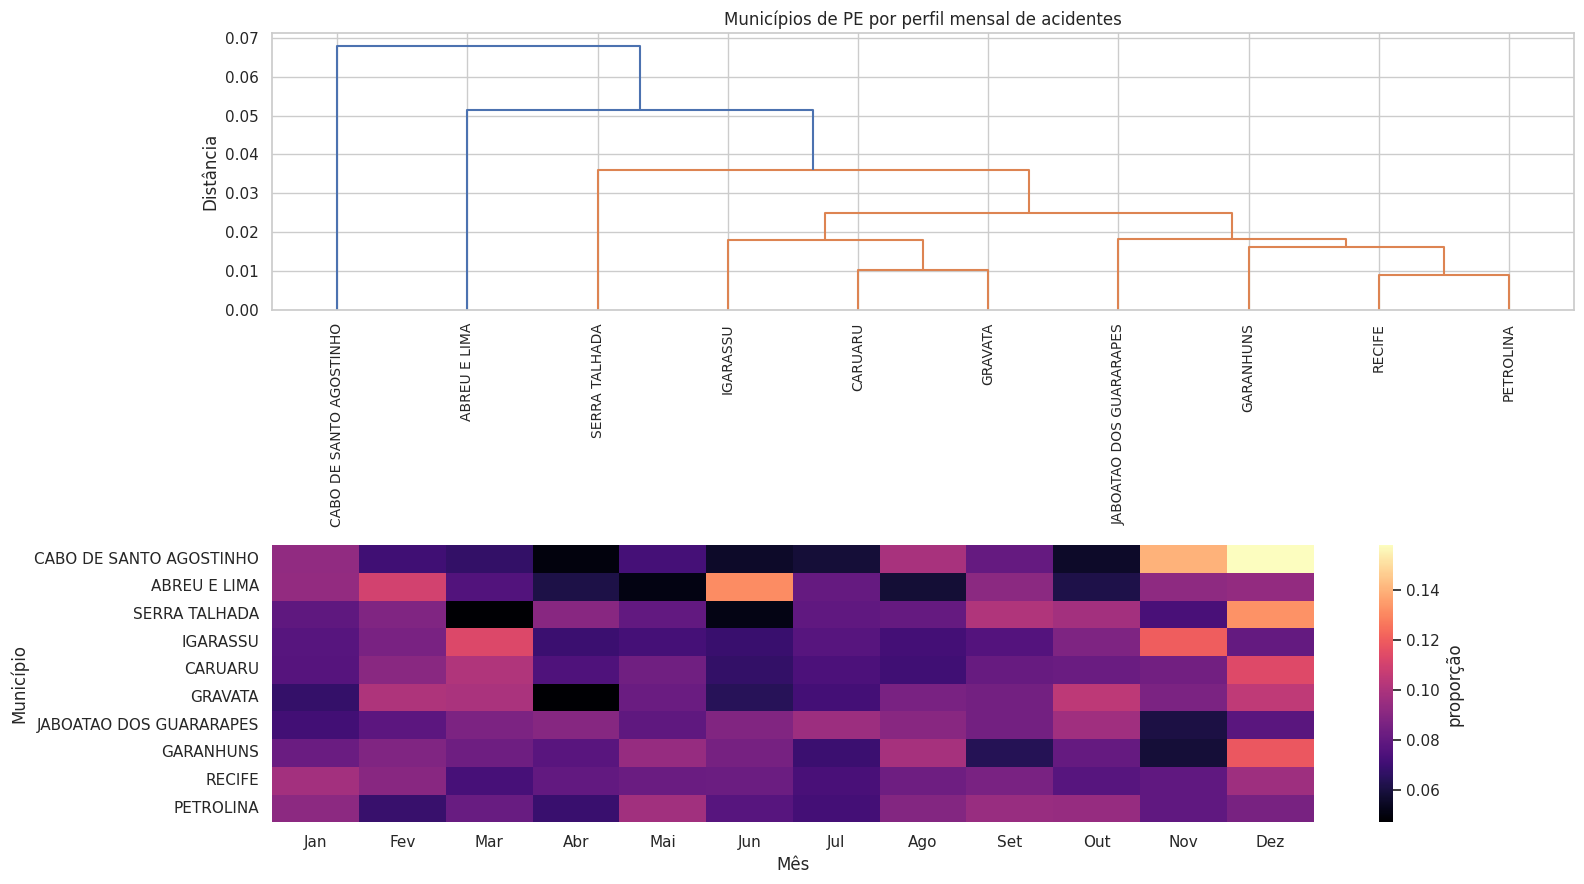

In [ ]:
sns.set(style="whitegrid")

dt  = pd.to_datetime(df_pe['data_inversa'], errors='coerce')
sub = pd.DataFrame({'municipio': df_pe['municipio'], 'mes': dt.dt.month}).dropna()
top_muns = sub['municipio'].value_counts().head(10).index
sub      = sub[sub['municipio'].isin(top_muns)]

tab = (sub.assign(c=1)
          .pivot_table(index='municipio', columns='mes', values='c',
                       aggfunc='sum', fill_value=0)
          .reindex(columns=range(1,13), fill_value=0)
          .loc[top_muns])
X = tab.div(tab.sum(axis=1), axis=0)

if X.shape[0] < 2: raise ValueError("Poucos municípios.")
Z = linkage(pdist(X.values, metric='cosine'), method='average')

fig = plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((2,1),(0,0))
d = dendrogram(Z, labels=X.index.tolist(), leaf_rotation=90, leaf_font_size=10, ax=ax1)
ax1.set_title('Municípios de PE por perfil mensal de acidentes'); ax1.set_ylabel('Distância')
order = d['leaves']; X_ord = X.iloc[order]

ax2 = plt.subplot2grid((2,1),(1,0))
month_names = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
sns.heatmap(X_ord.set_axis(month_names, axis=1), cmap='magma', cbar_kws={'label':'proporção'}, ax=ax2)
ax2.set_xlabel('Mês'); ax2.set_ylabel('Município')
plt.tight_layout(); plt.show()


Tipo de acidente x Faixa etária

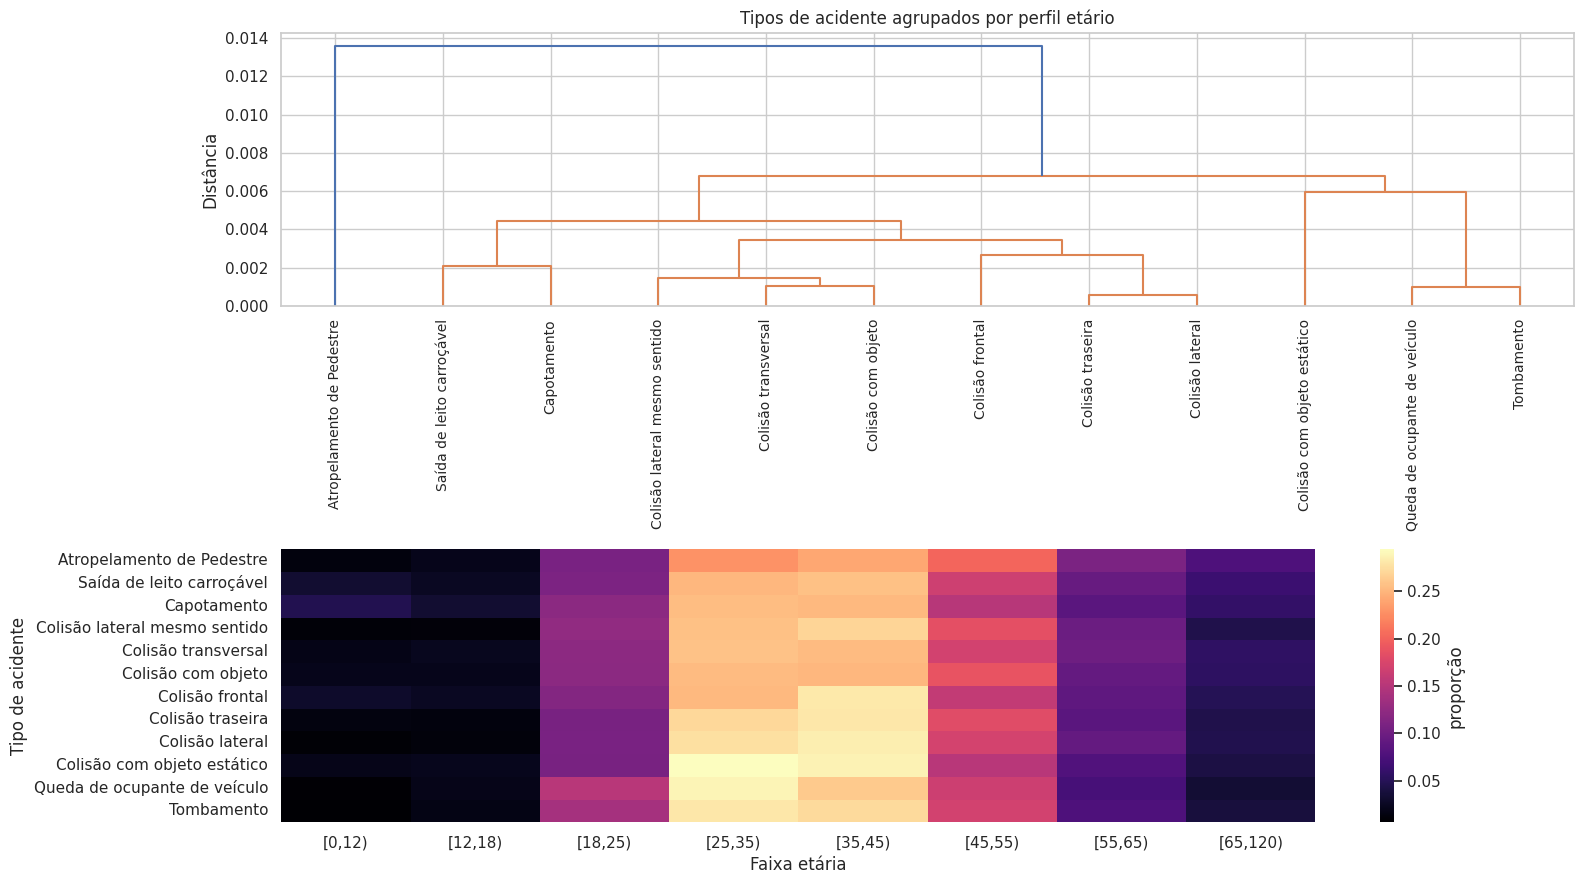

In [ ]:
sns.set(style="whitegrid")

sub = df_pe[['idade','tipo_acidente']].dropna().copy()
sub['idade'] = pd.to_numeric(sub['idade'], errors='coerce')
sub = sub[sub['idade'].between(0,100)]

top_types = sub['tipo_acidente'].value_counts().head(12).index
sub = sub[sub['tipo_acidente'].isin(top_types)]

bins = [0,12,18,25,35,45,55,65,120]
faixa = pd.cut(sub['idade'], bins=bins, right=False)

tab = (sub.assign(faixa=faixa, c=1)
          .pivot_table(index='tipo_acidente', columns='faixa', values='c',
                       aggfunc='sum', fill_value=0, observed=True)
          .loc[top_types])
X = tab.div(tab.sum(axis=1), axis=0)

if X.shape[0] < 2: raise ValueError("Poucos tipos de acidente.")
Z = linkage(pdist(X.values, metric='cosine'), method='average')

fig = plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((2,1),(0,0))
d = dendrogram(Z, labels=X.index.tolist(), leaf_rotation=90, leaf_font_size=10, ax=ax1)
ax1.set_title('Tipos de acidente agrupados por perfil etário'); ax1.set_ylabel('Distância')
order = d['leaves']; X_ord = X.iloc[order]

ax2 = plt.subplot2grid((2,1),(1,0))
col_labels = [f'[{iv.left:.0f},{iv.right:.0f})' for iv in X_ord.columns]
sns.heatmap(X_ord.set_axis(col_labels, axis=1), cmap='magma', cbar_kws={'label':'proporção'}, ax=ax2)
ax2.set_xlabel('Faixa etária'); ax2.set_ylabel('Tipo de acidente')
plt.tight_layout(); plt.show()


In [ ]:
# Converter para datetime e extrair o ano
df_pe["ano"] = pd.to_datetime(df_pe["data_inversa"], errors="coerce").dt.year

colunas_vitimas = ["mortos", "feridos_graves", "feridos_leves", "ilesos"]

# Agregar por município e ano
agg_mun_ano = (
    df_pe.groupby(["municipio", "ano"])[colunas_vitimas]
    .sum()
    .reset_index()
)

# Calcular a média anual por município
media_mun = (
    agg_mun_ano.groupby("municipio")[colunas_vitimas]
    .mean()
)

# Adicionar total de vítimas
media_mun["total_vitimas"] = media_mun.sum(axis=1)
media_mun = media_mun.round(0).astype(int)

# Ordenar pelo total de vítimas (ou mortos, se preferir)
media_mun = media_mun.sort_values(by="total_vitimas", ascending=False).head(25)

print("Top 25 municípios — Média mensal de vítimas de acidentes")
display(media_mun)


Top 25 municípios — Média anual de vítimas de acidentes


,mortos,feridos_graves,feridos_leves,ilesos,total_vitimas
municipio,,,,,
RECIFE,50,253,792,962,2057
JABOATAO DOS GUARARAPES,33,108,320,405,866
CARUARU,40,108,288,371,808
PETROLINA,43,107,301,349,800
IGARASSU,17,76,194,279,566
SERRA TALHADA,23,86,158,221,487
GARANHUNS,29,70,149,146,394
GRAVATA,19,69,115,156,359
CABO DE SANTO AGOSTINHO,19,57,119,157,351


## Exercício

Imagine que você é um planejador público federal e precisa usar dados para definir ações de atendimento médico nas estradas sob sua jurisdição (ou seja, as BRs) em Pernambuco. De posse dos dados de acidentes nos últimos anos, você será responsável por definir o seguinte:

1. Dado o conjunto das 25 cidades com maior número total de ocorrências e onde elas se localizam no mapa de Pernambuco, determine quais cidades poderiam fazer parte de cada cluster. Escolha o algoritmo de sua preferência e determine o número de clusters usando a regra do cotovelo.

2. Dividindo o estado na mesma quantidade de áreas obtidas no exercício anterior, você deverá definir que tipo de equipamento deverá ser construído em cada cluster da forma mais otimizada possível, de acordo com o número e a natureza da maioria dos acidentes. As suas opções são:

    a. ***Complexo terciário multidisciplinar (TERCs):*** Para tratamento dos casos mais graves e/ou com múltiplas vítimas, além de estrutura de Instituto Médico-Legal (IML) para os óbitos. Capacidade para atender mensalmente até 500 óbitos, 1200 atendimentos graves e 5000 atendimentos leves e ilesos. Custo operacional: R$ 10 milhões por mês por unidade.

    b. ***Clínicas de média complexidade (CMCs):*** Para tratamento dos ferimentos leves, com internação de no máximo poucos dias. Capacidade para atender mensalmente até 200 óbitos, 700 atendimentos graves e 2000 atendimentos leves e ilesos. Custo operacional: R$ 5 milhões por mês por unidade.

    c. ***Unidades de pronto atendimento (UPAs):*** Para acolhimento e observação dos ilesos (primeiros socorros, tratamento ambulatorial etc.) para saída em até 24 horas; eventuais óbitos são encaminhados para outras unidades. Capacidade para atender mensalmente 300 atendimentos graves e 1200 atendimentos leves e ilesos. Custo operacional: R$ 2 milhões por mês por unidade.

    ***OBSERVAÇÕES IMPORTANTES***:

    i. Os equipamentos mais complexos também são capazes de lidar com os menores casos. Baseie-se portanto na premissa de que, para esta etapa do planejamento, apenas uma unidade e único tipo de opção é necessária em cada cidade.

    ii. Dentro do possível, será interessante que os equipamentos estejam em cidades próximas entre si, para reduzir os deslocamentos.